In [1]:
from Discriminamometro import Utileria, Discriminamometro
import pandas as pd
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier


nlp = spacy.load('./data/embeddings_disc/')
# Se instancia la clase del Discriminamometro
obj_Discr = Discriminamometro('PRUEBA')

# Mostramos la cantidad de tweets
print(obj_Discr.nbr_TweetsXCorrida)

8


In [2]:
data = pd.read_csv("data/Tuits Discriminatorios - jul2020 - Muestra Tuits.csv")

In [3]:
data.columns = ['full_text', 'categoria', 'disc', 'Observaciones']
data["disc"] = data["disc"].replace(['???'],'SI')

In [4]:
data["disc"].value_counts()

NO    1208
SI     651
Name: disc, dtype: int64

In [5]:
data["disc"] = data["disc"].replace(['SI'],1)
data["disc"] = data["disc"].replace(['NO'],0)

In [6]:
data.head()

,full_text,categoria,disc,Observaciones
0,"!Viva la ""diversidad""! [?] \n\n!Proximamente e...",apariencia,0.0,capaz que la imagen es discriminatoria
1,@tennissucios @TenochHuerta Jajajaja... Muy ac...,apariencia,0.0,NaN
2,Hay momentos de la vida en los que te das cuen...,apariencia,0.0,NaN
3,@hornyboysmex @Hombres_sexgay Hermoso guerito !,apariencia,0.0,sextuiter es un mundo raro
4,Que restriccion tiene @DrGiammattei preparado ...,apariencia,0.0,NaN


In [7]:
obj_Discr.str_StopWords='StopWords.p'
obj_Discr.CargarStopWords()

data = obj_Discr.LimpiarDataFrame(data)
data = obj_Discr.QuitarStopWordsDataFrame(data)

In [8]:
data = data[data["full_text"].isnull()==False]

In [9]:
data = data[data["disc"].isnull()==False]

In [10]:
train, test = train_test_split(data, test_size=0.2,random_state = 202008)

In [11]:
npEmbeddings = np.empty([0, 300])

for texto in train['full_text']:
    
    #print(texto)
    
    # process a sentence using the model
    doc = nlp(texto)
    
    # print(doc.vector.shape)
    if doc.vector.shape[0]==300:
        npEmbeddings = np.append(npEmbeddings, [doc.vector], axis = 0)
    else:
        npAux = np.empty([1, 300])
        npEmbeddings = np.append(npEmbeddings, npAux, axis = 0)

npEmbeddings.shape

(1487, 300)

In [2]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import pandas as pd
import os

In [13]:
def Correr_Magic_Loop( npClassifier, npDictHyperParams, X_train, Y_train, nbrCv, strScoring):

        npResultados = np.array([])
        for i, classifier in enumerate(npClassifier):
            dictHyperParams = npDictHyperParams[i]
            grid_search = GridSearchCV(classifier,
                                       dictHyperParams,
                                       scoring=strScoring,
                                       cv=nbrCv,
                                       n_jobs=-1,
                                       verbose=3
                                       )
            grid_search.fit(X_train, Y_train)
            npResultados = np.append(npResultados, grid_search)

            # de los valores posibles que pusimos en el grid, cuáles fueron los mejores
            print('grid_search.best_params_: ', grid_search.best_params_)

            # mejor score asociado a los modelos generados con los diferentes hiperparametros
            # corresponde al promedio de los scores generados con los cv
            print('grid_search.best_score_: ', grid_search.best_score_)

            best_model = grid_search.best_estimator_


        return best_model, npResultados

In [14]:
def Prep_Modelos(npModelos):

    npArrayModelos = np.array([])
    for strModelo in npModelos:

        if strModelo == 'DECTREE':
            classifier = tree.DecisionTreeClassifier()
        if strModelo == 'RANDOMF':
            classifier = RandomForestClassifier()
        if strModelo == 'XGBOOST':
            classifier = GradientBoostingClassifier()

        npArrayModelos = np.append(npArrayModelos, classifier)

    return npArrayModelos

In [15]:
npDictHiperParam = np.array([]) 
# Parametrización para Árboles
dictHyperParams = {'max_depth': [4,7],  # 
                   'min_samples_split': [4,16],  # 
                   'min_samples_leaf': [3,7],  # 
                   'max_features': ['sqrt','log2']  # 
                   }
npDictHiperParam = np.append(npDictHiperParam, dictHyperParams)

# Parametrización para Bosques
dictHyperParams = {'n_estimators': [50],  # Se redujo a 50
                   'max_depth': [4,7],  # 
                   'max_features': ['sqrt','log2'],
                   'min_samples_split': [4,16],
                   'min_samples_leaf': [3,7]
                   }
npDictHiperParam = np.append(npDictHiperParam, dictHyperParams)

# Parametrización para XGBoost
dictHyperParams = {'learning_rate': [0.1,0.25, 0.75],
                   'n_estimators': [50,100,150],  # Se redujo a 50
                   'min_samples_split': [4,16],
                   'min_samples_leaf': [3,7],
                   'max_depth': [3,4,5,6,7,10,15],
                   'max_features': ['sqrt','log2']
                   }
npDictHiperParam = np.append(npDictHiperParam, dictHyperParams)

# Se crean los modelos de clasificaión que se emplearán (en el mismo orden que los diccionarios)
npNombreModelos = np.array([])
npNombreModelos = np.append(npNombreModelos, 'DECTREE')
npNombreModelos = np.append(npNombreModelos, 'RANDOMF')
npNombreModelos = np.append(npNombreModelos, 'XGBOOST')

In [16]:
X_train = pd.DataFrame(npEmbeddings)
Y_train = pd.DataFrame(train.disc)
arrModelos = Prep_Modelos(npNombreModelos)

# #Se corre el magic loop para realizar las predicciones con los parámetros previamente establecidos
best_model,npGridSearchCv = Correr_Magic_Loop(arrModelos,
                                    npDictHiperParam,
                                    X_train,
                                    Y_train,
                                    5,
                                    'roc_auc')

npArrBestScores = np.array([])
npArrBestParams = np.array([])

# Barremos el arreglo de GridSearchCV´s para sacar los mejores scores y parámetros
for grid in npGridSearchCv:
    npArrBestScores = np.append(npArrBestScores, grid.best_score_)
    npArrBestParams = np.append(npArrBestParams, grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


grid_search.best_params_:  {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 16}
grid_search.best_score_:  0.6970402098437019
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.3s finished
/home/francisco/anaconda3/envs/discriminamometro/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


grid_search.best_params_:  {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 16, 'n_estimators': 50}
grid_search.best_score_:  0.8070601656776073
Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:  5.6min finished
/home/francisco/anaconda3/envs/discriminamometro/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


grid_search.best_params_:  {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 100}
grid_search.best_score_:  0.8213498004621058


In [17]:
# Obtenemos el índice del mejor score
nbrIndiceGanador = np.argmax(npArrBestScores, axis=0)

# Mostramos el modelo, parámetros y score ganador
# print("Modelo ganador: \n", arrModelos[nbrIndiceGanador])
# print("Score del modelo ganador: \n", npArrBestScores[nbrIndiceGanador])
# print("Parametros del modelo ganador: \n", npArrBestParams[nbrIndiceGanador])

# Se instancia el modelo ganador
# self.ModeloGanadorMagicLoop = objEda.InstanciarModeloDinamico(npNombreModelos, nbrIndiceGanador, npArrBestParams[nbrIndiceGanador])
ModeloGanadorMagicLoop = best_model

In [18]:
ModeloGanadorMagicLoop

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=7, min_samples_split=4,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Desempeño en test

In [19]:
npEmbeddings2 = np.empty([0, 300])
for texto in test['full_text']:
    
    #print(frase)
    
    # process a sentence using the model
    doc = nlp(texto)
    
    # print(doc.vector.shape)
    #print(npEmbeddings.shape)
    #print(doc.vector.shape)
    
    if doc.vector.shape[0]==300:
        npEmbeddings2 = np.append(npEmbeddings2, [doc.vector], axis = 0)
    else:
        npAux = np.empty([1, 300])
        doc = nlp('prueba')
        #npEmbeddings = np.append(npEmbeddings, npAux, axis = 0)
        npEmbeddings2 = np.append(npEmbeddings2, [doc.vector], axis = 0)
        predicted_svm = clf.predict([doc.vector])
        
npEmbeddings2.shape

(372, 300)

In [20]:
import pickle as pickle

pickleFile = open('modelo_clasificacion_binaria_2.p', 'wb')
pickle.dump(best_model, pickleFile)
pickleFile.close()

In [44]:
predicted_svm = best_model.predict(npEmbeddings2)
np.mean(predicted_svm == test.disc)

0.7688172043010753

In [41]:
tweet = 'cojo rico'
npAux = nlp(tweet).vector
predicted_svm = best_model.predict([npAux])
predicted_prob = best_model.predict_proba([npAux])
print(predicted_prob)
if(predicted_svm==0):
    print('No discriminación')
else:
    print('Si discrimina')

[[0.46445391 0.53554609]]
Si discrimina


In [24]:
y_probas = best_model.predict_proba(npEmbeddings2)
y_true = test.disc
y_prob = pd.DataFrame(y_probas)
y_prob.columns = ["cero","uno"]
y_prob = y_prob["uno"]

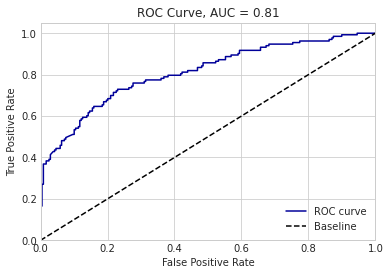

In [25]:
from sklearn import metrics
from matplotlib import pyplot as plt 

#Definimos la funcion que graficará la ROC
def plot_ROC(test_labels, test_predictions):
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, 
                                             test_predictions, pos_label=1)
    auc = "%.2f" % metrics.auc(fpr, tpr)
    title = 'ROC Curve, AUC = '+str(auc)
    with plt.style.context(('seaborn-whitegrid')):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "#000099", label='ROC curve')
        ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.title(title)
    return  
plot_ROC(y_true, y_prob) 

Confusion matrix, without normalization
[[222  17]
 [ 69  64]]
Normalized confusion matrix
[[0.92887029 0.07112971]
 [0.51879699 0.48120301]]


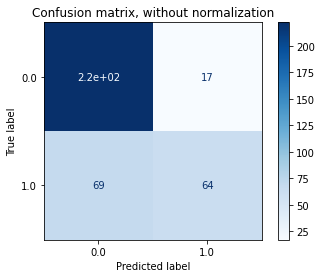

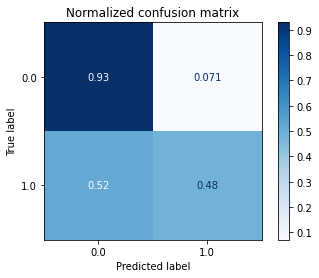

In [42]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(best_model, npEmbeddings2, y_true,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, predicted_svm)

array([[222,  17],
       [ 69,  64]])

In [6]:
import pickle as pickle

pickleFile = open('modelo_capa2_genero.p', 'rb')
modelo2 = pickle.load(pickleFile)
pickleFile.close()

/home/francisco/anaconda3/envs/discriminamometro/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/francisco/anaconda3/envs/discriminamometro/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/francisco/anaconda3/envs/discriminamometro/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
